This version of the snake game allows you to implement and run your evolutionary algorithm


In [1]:
import random
import time
import turtle
import numpy as np
import math


In [2]:
# Number of grid cells in each direction (do not change this)
XSIZE = YSIZE = 16


Change headless to True when evolving your solution. You can then pickle your final solution, and run it with this set to True to visualize the result, if you wish. Note that, when using Turtle, to run it again properly you might need to go to restart your kernel after the visualization has finished.


If you are running on the cloud, or on Google Colab, you can chose to remove the turtle and display code altogether and only run headless. You could then pickle your best solution and use this code to see it play.


In [3]:
HEADLESS = True
QUIET = True


In [4]:
class DisplayGame:
  def __init__( self, XSIZE, YSIZE):
    # SCREEN
    self.win = turtle.Screen()
    self.win.title("EVCO Snake game")
    self.win.bgcolor("grey")
    self.win.setup(width=(XSIZE*20)+40, height=(YSIZE*20)+40)
    # self.win.screensize((XSIZE*20)+20,(YSIZE*20)+20)
    self.win.tracer(0)

    # Snake Head
    self.head = turtle.Turtle()
    self.head.shape("square")
    self.head.color("black")

    # Snake food
    self.food = turtle.Turtle()
    self.food.shape("circle")
    self.food.color("yellow")
    self.food.penup()
    self.food.shapesize(0.55, 0.55)
    self.segments = []

  def reset(self, snake):
    self.segments = []
    self.head.penup()
    self.food.goto(-500, -500)
    self.head.goto(-500, -500)
    for i in range(len(snake)-1):
      self.add_snake_segment()
    self.update_segment_positions(snake)

  def update_food(self, new_food):
    self.food.goto(((new_food[1]-9)*20)+20, (((9-new_food[0])*20)-10)-20)

  def update_segment_positions(self, snake):
    self.head.goto(((snake[0][1]-9)*20)+20, (((9-snake[0][0])*20)-10)-20)
    for i in range(len(self.segments)):
      self.segments[i].goto(((snake[i+1][1]-9)*20)+20,
                            (((9-snake[i+1][0])*20)-10)-20)

  def add_snake_segment(self):
    self.new_segment = turtle.Turtle()
    self.new_segment.speed(0)
    self.new_segment.shape("square")
    # random.choice(["green", 'black', 'red', 'blue']))
    self.new_segment.color("green")
    self.new_segment.penup()
    self.segments.append(self.new_segment)


In [5]:
class snake:
  def __init__(self, _XSIZE, _YSIZE):
    self.XSIZE = _XSIZE
    self.YSIZE = _YSIZE
    self.reset()

  def reset(self):
    self.snake = [[8, 10], [8, 9], [8, 8], [8, 7], [8, 6], [8, 5], [8, 4], [
        8, 3], [8, 2], [8, 1], [8, 0]]  # Initial snake co-ordinates [ypos,xpos]
    self.food = self.place_food()
    self.snake_direction = "right"

  def place_food(self):
    self.food = [random.randint(1, (YSIZE-2)),
                 random.randint(1, (XSIZE-2))]
    while (self.food in self.snake):
      self.food = [random.randint(
          1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
    return(self.food)

  def update_snake_position(self):
    self.snake.insert(0, [self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1),
                      self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)])

  def food_eaten(self):
    # When snake eats the food
    if self.snake[0] == self.food:
      return True
    else:
      # [1] If it does not eat the food, it moves forward and so last tail item is removed
      last = self.snake.pop()
      return False

  def snake_turns_into_self(self):
    if self.snake[0] in self.snake[1:]:
      return True
    else:
      return False

  def snake_hit_wall(self):
    if self.snake[0][0] == 0 or self.snake[0][0] == (YSIZE-1) or self.snake[0][1] == 0 or self.snake[0][1] == (XSIZE-1):
      return True
    else:
      return False

  def manhattanDistance(self, pos):
    return abs(pos[0]-self.food[0])+abs(pos[1]-self.food[1])

  def senseWall(self, pos):
    return(pos[0] < 0 or pos[0] > (YSIZE-1) or pos[1] < 0 or pos[1] > (XSIZE-1))

  def senseTail(self, pos):
    return pos in self.snake


  def leftWall(self):
    return self.senseWall([self.snake[0][0],self.snake[0][1]-1])

  def leftTail(self):
    return self.senseTail([self.snake[0][0],self.snake[0][1]-1])

  def leftFood(self):
    return self.food[1] < self.snake[0][1]

  def rightWall(self):
    return self.senseWall([self.snake[0][0],self.snake[0][1]+1])

  def rightTail(self):
    return self.senseTail([self.snake[0][0],self.snake[0][1]+1])

  def rightFood(self):
    return self.food[1] > self.snake[0][1]

  def upWall(self):
    return self.senseWall([self.snake[0][0]-1,self.snake[0][1]])

  def upTail(self):
    return self.senseTail([self.snake[0][0]-1,self.snake[0][1]])

  def upFood(self):
    return self.food[0] < self.snake[0][0]

  def downWall(self):
    return self.senseWall([self.snake[0][0]+1,self.snake[0][1]])

  def downTail(self):
    return self.senseTail([self.snake[0][0]+1,self.snake[0][1]])

  def downFood(self):
    return self.food[0] > self.snake[0][0]

  def getDistanceToFood(self):
    return math.sqrt((abs(self.food[0]-self.snake[0][0]) ** 2) + (abs(self.food[1]-self.snake[0][1]) ** 2))



In [6]:
snake_game = snake(XSIZE, YSIZE)


In [7]:
if not HEADLESS:
  display = DisplayGame(XSIZE, YSIZE)


In [8]:
def run_game(network, display, snake_game, headless):

  score = 0
  timeAlive = 0
  timeSinceNom = 0
  snake_game.reset()
  if not headless:
    display.reset(snake_game.snake)
    display.win.update()
  snake_game.place_food()
  game_over = False

  while not game_over:
    timeAlive+=1
    timeSinceNom+=1
    # ****YOUR AI BELOW HERE******************

    inputs = [  snake_game.leftWall() or snake_game.leftTail(), snake_game.leftFood(),
                snake_game.rightWall() or snake_game.rightTail(), snake_game.rightFood(),
                snake_game.upWall() or snake_game.upTail(), snake_game.upFood(),
                snake_game.downWall() or snake_game.downTail(), snake_game.downFood(),
                ]
    #print(inputs)
    output = network.feedForward(inputs)
    decision = np.argmax(output, axis=0)
    if decision == 0:
      snake_game.snake_direction = "left"
    elif decision == 1:
      snake_game.snake_direction = "right"
    elif decision == 2:
      snake_game.snake_direction = "up"
    elif decision == 3:
      snake_game.snake_direction = "down"

    # ****YOUR AI ABOVE HERE******************

    snake_game.update_snake_position()

    # Check if food is eaten
    if snake_game.food_eaten():
      timeSinceNom=0
      snake_game.place_food()
      score += 1
      if not headless:
        display.add_snake_segment()

    # Game over if the snake runs over itself
    if snake_game.snake_turns_into_self():
      game_over = True
      #print("Snake turned into itself!")

    # Game over if the snake goes through a wall
    if snake_game.snake_hit_wall():
      game_over = True
      #print("Snake hit a wall!")
    if(timeSinceNom > 50):
      timeAlive-=50
      game_over = True
    #if(timeAlive % 50 == 0):
      
    if not headless:
      display.update_food(snake_game.food)
      display.update_segment_positions(snake_game.snake)
      display.win.update()
      # Change this to modify the speed the game runs at when displayed.
      time.sleep(0.2)

  if not headless:
    turtle.done()
    try:
      turtle.bye()
    except turtle.Terminator:
      pass
    print("\nFINAL score - " +  str(score))

  #boardHyp = math.sqrt(XSIZE ** 2 + YSIZE ** 2)
  # score  + ((boardHyp - snake_game.getDistanceToFood()) / boardHyp)
  return (score ** 3) * timeAlive, score


In [9]:
class MLP(object):
  def __init__(self, numInput, numHidden1, numHidden2, numOutput):
    self.fitness = 0
    self.numInput = numInput + 1  # Add bias node from input to hidden layer 1 only
    # Feel free to adapt the code to add more biases if you wish
    self.numHidden1 = numHidden1
    self.numHidden2 = numHidden2
    self.numOutput = numOutput

    self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput)
    self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1)
    self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

    self.ReLU = lambda x: max(0, x)

  def softmax(self, x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

  def feedForward(self, inputs):
    inputsBias = inputs[:]
    inputsBias.insert(len(inputs), 1)             # Add bias input

    # feed input to hidden layer 1
    h1 = np.dot(self.w_i_h1, inputsBias)
    h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1

    # feed layer 1 to hidden layer 2
    h2 = np.dot(self.w_h1_h2, h1)
    h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

    output = np.dot(self.w_h2_o, h2)             # feed to output layer
    # output = [self.sigmoid(x) for x in output]   # Activate output layer
    return self.softmax(output)

  def getWeightsLinear(self):
    flat_w_i_h1 = list(self.w_i_h1.flatten())
    flat_w_h1_h2 = list(self.w_h1_h2.flatten())
    flat_w_h2_o = list(self.w_h2_o.flatten())
    return(flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_o)

  def setWeightsLinear(self, Wgenome):
    numWeights_I_H1 = self.numHidden1 * self.numInput
    numWeights_H1_H2 = self.numHidden2 * self.numHidden1
    numWeights_H2_O = self.numOutput * self.numHidden2

    self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
    self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))

    self.w_h1_h2 = np.array(
        Wgenome[numWeights_I_H1:(numWeights_H1_H2+numWeights_I_H1)])
    self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

    self.w_h2_o = np.array(Wgenome[(numWeights_H1_H2+numWeights_I_H1):])
    self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))


In [10]:
from deap import base
from deap import creator
from deap import tools
from datetime import datetime

random.seed(datetime.now())  # Set a random seed from the clock

numInputNodes = 8
numHiddenNodes1 = 12
numHiddenNodes2 = 12
numOutputNodes = 4

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) + (numHiddenNodes1 *
                                                    numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes)

network = MLP(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

toolbox.register("mate", tools.cxOnePoint)


def evaluate(indiv, network):
  fitness = 0
  network.setWeightsLinear(indiv)
  fitness,score = run_game(network, display, snake_game, headless=HEADLESS)
  return ((fitness,), score)


toolbox.register("evaluate", evaluate)


toolbox.register("select", tools.selTournament, tournsize=5)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.01)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


logbook = tools.Logbook()


NGEN = 500
CXPB = 0.0
MUTPB = 1
POP = 500

pop = toolbox.population(n=POP)
fitnesses = []
scores = []
for indiv in pop:
  fitness, score = toolbox.evaluate(indiv, network)
  fitnesses.append(fitness)
  scores.append(score)
for ind, fit in zip(pop, fitnesses):
  ind.fitness.values = fit


for g in range(NGEN):
  print("-- Generation %i --" % g)

  offspring = toolbox.select(pop, len(pop))
  offspring = list(map(toolbox.clone, offspring))

  for child1, child2 in zip(offspring[::2], offspring[1::2]):
    if random.random() < CXPB:
      toolbox.mate(child1, child2)
      del child1.fitness.values
      del child2.fitness.values

  for mutant in offspring:
    if random.random() < MUTPB:
      toolbox.mutate(mutant)
      del mutant.fitness.values

  invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
  fitnesses = []
  scores = []
  for indiv in invalid_ind:
    fitness, score = toolbox.evaluate(indiv, network)
    fitnesses.append(fitness)
    scores.append(score)
  for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

  pop[:] = offspring
  record = stats.compile(pop)
  logbook.record(gen=g, **record)
  print("Max: " + str(np.max(scores)))
  print("Mean: " + str(np.mean(scores)))


-- Generation 0 --
Max: 2
Mean: 0.034
-- Generation 1 --
Max: 2
Mean: 0.042
-- Generation 2 --
Max: 1
Mean: 0.066
-- Generation 3 --
Max: 2
Mean: 0.086
-- Generation 4 --
Max: 1
Mean: 0.09
-- Generation 5 --
Max: 2
Mean: 0.162
-- Generation 6 --
Max: 2
Mean: 0.18
-- Generation 7 --
Max: 2
Mean: 0.174
-- Generation 8 --
Max: 3
Mean: 0.208
-- Generation 9 --
Max: 2
Mean: 0.234
-- Generation 10 --
Max: 2
Mean: 0.25
-- Generation 11 --
Max: 2
Mean: 0.286
-- Generation 12 --
Max: 2
Mean: 0.268
-- Generation 13 --
Max: 2
Mean: 0.268
-- Generation 14 --
Max: 3
Mean: 0.266
-- Generation 15 --
Max: 2
Mean: 0.318
-- Generation 16 --
Max: 2
Mean: 0.344
-- Generation 17 --
Max: 2
Mean: 0.324
-- Generation 18 --
Max: 2
Mean: 0.288
-- Generation 19 --
Max: 3
Mean: 0.334
-- Generation 20 --
Max: 2
Mean: 0.336
-- Generation 21 --
Max: 2
Mean: 0.324
-- Generation 22 --
Max: 2
Mean: 0.34
-- Generation 23 --
Max: 2
Mean: 0.344
-- Generation 24 --
Max: 2
Mean: 0.346
-- Generation 25 --
Max: 3
Mean: 0.368


KeyboardInterrupt: 

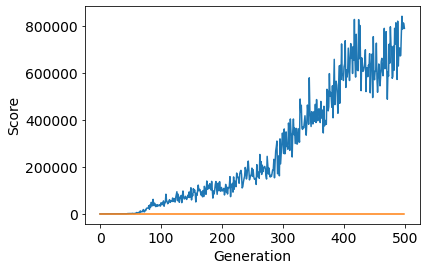

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = logbook.select("gen")
_min = logbook.select("min")
_max = logbook.select("max")
avgs = logbook.select("avg")
stds = logbook.select("std")

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Score")

line2 = ax1.plot(gen, _min)
#line3 = ax1.plot(gen, _max)


In [ ]:

bestInd = tools.selBest(pop, 1)[0]

network.setWeightsLinear(bestInd)

display = DisplayGame(XSIZE, YSIZE)

print(run_game(network, display, snake_game, headless=False))



FINAL score - 18
(991440, 18)


Below is what you would use for your evaluation. You would also use it to display your final (pickled and loaded) solution, with headless = False.


If you have run without headless (i.e. with the display) you will need to reset your kernel to run again. This appears to be an IPython issue with Turtle, but if you have a way to deal with that, do please let me know. You will probable only want to run it one-at-a-time anyway.
